**Vertical Strategy: Use text column to predict tex_paragraph column**

**Outline**

1. ✅ filter out stopwords in text column
    - word tokenize text column
2. ✅  use token match in big string to define candidate paragraphs
    - merge overlapping paragraphs
3. ✅ Score/rank paragraphs
    - some terms will be more relevant/weighted than others
    - also score them by requency
4. ✅ Check similarity between predicted paragraphs and actual paragraphs

# Vertical Pipeline: turn vertical strategy into something easily iterable
- like a function callable on an html that returns a nominated paragraph

In [130]:
import os
import glob

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from collections import Counter

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import datetime

## Generate parameters from curated training data

### read in the vertical training subset data frame

In [17]:
### read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(2)

In [ ]:
### these are the only dkfns that I'm currently working with
print(set(vert_training_subset_df.data_key_friendly_name))

### generate key_tokens from text colum

In [15]:
### compile a string from the text column

text_list = [t.lower() for t in vert_training_subset_df.text]
#print('This is what the text_list looks like: ')
#print("----------------------------")
#print(text_list[0:3])
#print("----------------------------")
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '
#print("")
#print("And now this is what the flattened text_string looks like: ")
#print("----------------------------")
#print(text_string[0:250])
#print("----------------------------")

In [23]:
### tokenize the text string

text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]
#print(no_stops[0:10])

### limit ourselves to the 30 most common tokens
    # although this can be modulated if necessary
key_tokens = pd.DataFrame(Counter(no_stops).most_common(30))
key_tokens.columns = ['key_tok', 'kt_count']

can probably improve the above list of key_tokens by using less than 30 terms.... maybe

#### 🤔 I could enhance my key_tokens by doing tf-idf
- between the text column and the the html text - the text column
    - which terms are prominent in text column that are not prominent in the rest of the html
    - which terms are prominent in the noisy signal that are not prominent in the noise?
- I could also enhance it by removing noisy words like 'total'

### define paragraph margins
as the standard deviation of paragraph lengths

In [22]:
par_lengths = [len(par) for par in vert_training_subset_df.paragraph_text]
margin = int(np.std(par_lengths))

## This will be the beginning of the loop
1. read in a filing
2. call a function that
    - defines candidate paragraphs
    - ranks or scores candidate paragraphs to select top nominee(s)
    - validates if predicted nominee is a good match to actual paragraph in the training csv.

### Stage filings to be read in iterably

In [20]:
# initialize a list of paths
training_filings_list = []

# populate the list
for root, dirs, files in os.walk('data/nc_training_filings/'):
    training_filings_list += glob.glob(os.path.join(root, '*.html'))
#print(training_filings_list[0:3])

### for now, isolate only those filings which are in my vertical training df

In [39]:
len(set(vert_training_subset_df.accession_number))

278

In [42]:
len(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))

278

In [47]:
vert_training_subset_filings_list = list(set(['data/nc_training_filings/' + an + '.html' for an in vert_training_subset_df.accession_number]))
vert_training_subset_filings_list
assert len(vert_training_subset_filings_list) == len(set(vert_training_subset_df.accession_number))

In [106]:
len(vert_training_subset_filings_list)

278

# for now, lets practice on only filings in vertical_training_subset
processing 278 filings from vert_training_subset_filings_list takes about 7 minutes, 45 seconds
- there are lots of optimizations I could do if it becomes necessary

In [172]:
# initialize some score keeping lists
total_inclusion = []
inclusion_rates = [] # analogous to true positive rate
extra_baggage_rate = [] # analogous to false positive rate, (sorta, cause the actual paragraph data is not to be treated as an absolute standard).
actual_paratokens_lengths = []
nominated_paratokens_lengths = []

t0 = datetime.datetime.now()

#for filing in training_filings_list:
#for filing in vert_training_subset_filings_list[0:100]:
for filing in vert_training_subset_filings_list:
    ti = datetime.datetime.now()
    print('processing next filing at ', ti)
    
    
### this could be all be packed into a function if nec.
###
    # read in the filing's html
    with open(filing) as file:
        file_html = file.read()
    
    # parse the html
    parsed_html = BeautifulSoup(file_html)
    # filter out the html head, css, and cast to lower case
    string_filing = parsed_html.body.text.lower()
    
    ################################################################
    #define candidate paragraphs by clustering of overlapping token-hit-margins
    #
    #------ generate a list of token mathces / "hits"------------------------------
    #
    # collect the start and end indices of each token "hit." into an ugly list of lists of tuples
    lst_of_token_hits_lst = []
    for i in range(len(key_tokens.key_tok[0:10])):
        kt = key_tokens.key_tok[i]
        lst_of_token_hits_lst.append([(str(kt), m.start(), m.end()) for m in re.finditer(kt, string_filing)])
    #
    # flatten the ugly list of lists of tuples into a list of tuples
    flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
    #
    # order the list of token_hit tuples by starting index
    flater_list_of_tokhits.sort(key = lambda x: x[1])
    #
    #-------- use the token hits to define the bounds of the candidate paragraphs -------
    #
    # initialize a list of candidate paragraphs and a hit tracker
    candidate_paragraphs = []
    hit = 0
    #
    # work through the hits until I exhaust the list
    while hit < len(flater_list_of_tokhits) - 1:
    #    
        # initialize the left and right bound of a paragraph
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
    #     
        # loop from the hit + 1 (cause we used the former hit to initialize the bounds)
        for i in range(hit + 1, len(flater_list_of_tokhits)):
            # if the next token's start is within the current paragraph's bounds and it isnt the last hit
            if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
                # expand the right bound with respect to next token's end
                rightbound = flater_list_of_tokhits[i][2] + margin
    #             
            # if next token is outside the bounds of current paragraph or we are at the penultimate hit
            else:
                # if right bound is out of htmls range, then adjust it to the end of the html
                if rightbound > len(string_filing):
                    rightbound = len(string_filing)
                # define current paragraph
                par = string_filing[leftbound:rightbound] ########### (if the code needs to be made more efficient I could store the paragraph start and end indices instead of storing the strings)
                # store the paragraph in a list of candidates
                candidate_paragraphs.append(par)
                # note which hit we need to start on for the next iteration of the while loop
                hit = i
                # now that we've found the outer bounds of the current paragraph we can interrupt the for loop
                break #this won't interrupt the while loop 😊 
    #
    # this is just a repetition of the above routine to handle the last hit. There is probably a better way to handle this but we can enhance that later
    if hit == len(flater_list_of_tokhits)-1:
        leftbound = flater_list_of_tokhits[hit][1] - margin
        rightbound = flater_list_of_tokhits[hit][2] + margin
        if rightbound > len(string_filing):
            rightbound = len(string_filing)
        par = string_filing[leftbound:rightbound]
        candidate_paragraphs.append(par)
    #
    # --------------- store the candidate paragraphs in a df ------------------
    candidate_df = pd.DataFrame(candidate_paragraphs)
    candidate_df.columns = ['cand_par']
    candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
    # --------------- rank the candidate paragraphs by basic length (longer paragraphs correspond to denser clusters)
    candidate_df.sort_values(by = 'len', ascending = False, inplace = True)
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- filter candidates downto those with 'repurchase' in them
    candidate_df = candidate_df[['repurchase' in par for par in candidate_df.cand_par]]
    candidate_df.reset_index(inplace = True, drop = True)
    # --------------- nominee(s) will be the top 1 - 3 in the filterd df
    nominated = candidate_df.cand_par[0]
    # clean up the nominee for validation
    nom_validatable = re.sub(r'\n+', ' ', nominated) # remove new lines
    nom_validatable = re.sub(r'\s+', ' ', nom_validatable) # trim all repeated whitespace down to one
    # filter out stop words and non-alphanumeric content
    # apply the same filtering process to nom_validatable
    nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))] # yes there is redundancy but that can be optimized later
    
    # --------------- isolate csv's actual paragraph for valiation
    # extract the accesion number back out of the filing path
    an = re.sub('data/nc_training_filings/', '', filing)
    an = re.sub('.html', '', an)
    # use it to filter down to the csv rows with that an
    actual_paragraph = vert_training_subset_df[vert_training_subset_df.accession_number == an].head(1).paragraph_text
    # extract the string from the resulting pandas series
    actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
    actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
    actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
    # filter out stop words, punctuation, and other non-alphanumeric stuff
    actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))] #yes there is probably some redundancy here but that can be refined later
    
    # moment of truth
    #---------------------------------------------------------
    #print('Actual_paragraph in nom_validatable: ')
    #print('----------', actual_paragraph in nom_validatable)
    
    # calculate the inclusion rates
    counter = 0
    for wt in actual_tokens:
        if wt in nominated_tokens:
            counter += 1
    #print('actual tokens also in nominated_tokens')
    #print('---------- counter = ', counter)
    x = round(100*counter/len(actual_tokens),2)
    #print('that is a ', x, '% inclusion')
    #print("---------------------------------")
    #print("")
    
    # calculate the extra_baggage_rates
    bag_counter = 0
    for wt in nominated_tokens:
        if wt in actual_tokens:
            bag_counter += 1
    z = round(100*bag_counter/len(nominated_tokens), 2)
    
    # keeping score
    # ---------------------------------------------------------
    total_inclusion.append(actual_paragraph in nom_validatable)
    inclusion_rates.append(x)
    extra_baggage_rate.append(z)
    actual_paratokens_lengths.append(len(actual_tokens))
    nominated_paratokens_lengths.append(len(nominated_tokens))
    
    tf = datetime.datetime.now()
    print('finished processing ', len(total_inclusion), 'th filing at ', tf)
    print('process took', tf - ti)
    print("--------------------------")

print("")
print('entire cycle took ', tf - t0)

processing next filing at  2018-06-03 22:42:33.465245


/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


finished processing  1 th filing at  2018-06-03 22:42:37.436322
process took 0:00:03.971077
--------------------------
processing next filing at  2018-06-03 22:42:37.436545
finished processing  2 th filing at  2018-06-03 22:42:39.193719
process took 0:00:01.757174
--------------------------
processing next filing at  2018-06-03 22:42:39.193919
finished processing  3 th filing at  2018-06-03 22:42:40.615591
process took 0:00:01.421672
--------------------------
processing next filing at  2018-06-03 22:42:40.615815
finished processing  4 th filing at  2018-06-03 22:42:41.557605
process took 0:00:00.941790
--------------------------
processing next filing at  2018-06-03 22:42:41.558137
finished processing  5 th filing at  2018-06-03 22:42:43.296119
process took 0:00:01.737982
--------------------------
processing next filing at  2018-06-03 22:42:43.296363
finished processing  6 th filing at  2018-06-03 22:42:45.244627
process took 0:00:01.948264
--------------------------
processing next 

finished processing  49 th filing at  2018-06-03 22:43:58.368932
process took 0:00:03.030363
--------------------------
processing next filing at  2018-06-03 22:43:58.369102
finished processing  50 th filing at  2018-06-03 22:43:59.655949
process took 0:00:01.286847
--------------------------
processing next filing at  2018-06-03 22:43:59.656209
finished processing  51 th filing at  2018-06-03 22:44:00.761311
process took 0:00:01.105102
--------------------------
processing next filing at  2018-06-03 22:44:00.761491
finished processing  52 th filing at  2018-06-03 22:44:01.875400
process took 0:00:01.113909
--------------------------
processing next filing at  2018-06-03 22:44:01.875611
finished processing  53 th filing at  2018-06-03 22:44:03.819571
process took 0:00:01.943960
--------------------------
processing next filing at  2018-06-03 22:44:03.819795
finished processing  54 th filing at  2018-06-03 22:44:05.705166
process took 0:00:01.885371
--------------------------
processing

finished processing  97 th filing at  2018-06-03 22:45:13.169192
process took 0:00:01.697989
--------------------------
processing next filing at  2018-06-03 22:45:13.169396
finished processing  98 th filing at  2018-06-03 22:45:14.542695
process took 0:00:01.373299
--------------------------
processing next filing at  2018-06-03 22:45:14.543289
finished processing  99 th filing at  2018-06-03 22:45:15.801278
process took 0:00:01.257989
--------------------------
processing next filing at  2018-06-03 22:45:15.801506
finished processing  100 th filing at  2018-06-03 22:45:17.499567
process took 0:00:01.698061
--------------------------
processing next filing at  2018-06-03 22:45:17.499798
finished processing  101 th filing at  2018-06-03 22:45:18.850305
process took 0:00:01.350507
--------------------------
processing next filing at  2018-06-03 22:45:18.851072
finished processing  102 th filing at  2018-06-03 22:45:19.852745
process took 0:00:01.001673
--------------------------
process

finished processing  144 th filing at  2018-06-03 22:46:31.486259
process took 0:00:02.643777
--------------------------
processing next filing at  2018-06-03 22:46:31.486495
finished processing  145 th filing at  2018-06-03 22:46:32.289839
process took 0:00:00.803344
--------------------------
processing next filing at  2018-06-03 22:46:32.290110
finished processing  146 th filing at  2018-06-03 22:46:32.829389
process took 0:00:00.539279
--------------------------
processing next filing at  2018-06-03 22:46:32.829599
finished processing  147 th filing at  2018-06-03 22:46:34.015839
process took 0:00:01.186240
--------------------------
processing next filing at  2018-06-03 22:46:34.016026
finished processing  148 th filing at  2018-06-03 22:46:35.115538
process took 0:00:01.099512
--------------------------
processing next filing at  2018-06-03 22:46:35.116886
finished processing  149 th filing at  2018-06-03 22:46:36.248417
process took 0:00:01.131531
--------------------------
proc

finished processing  191 th filing at  2018-06-03 22:47:45.189703
process took 0:00:02.623653
--------------------------
processing next filing at  2018-06-03 22:47:45.189903
finished processing  192 th filing at  2018-06-03 22:47:46.195102
process took 0:00:01.005199
--------------------------
processing next filing at  2018-06-03 22:47:46.195340
finished processing  193 th filing at  2018-06-03 22:47:47.797944
process took 0:00:01.602604
--------------------------
processing next filing at  2018-06-03 22:47:47.798105
finished processing  194 th filing at  2018-06-03 22:47:48.697840
process took 0:00:00.899735
--------------------------
processing next filing at  2018-06-03 22:47:48.698016
finished processing  195 th filing at  2018-06-03 22:47:51.678463
process took 0:00:02.980447
--------------------------
processing next filing at  2018-06-03 22:47:51.678749
finished processing  196 th filing at  2018-06-03 22:47:53.635272
process took 0:00:01.956523
--------------------------
proc

finished processing  238 th filing at  2018-06-03 22:49:03.465369
process took 0:00:01.454696
--------------------------
processing next filing at  2018-06-03 22:49:03.465666
finished processing  239 th filing at  2018-06-03 22:49:04.625995
process took 0:00:01.160329
--------------------------
processing next filing at  2018-06-03 22:49:04.626171
finished processing  240 th filing at  2018-06-03 22:49:05.889212
process took 0:00:01.263041
--------------------------
processing next filing at  2018-06-03 22:49:05.889425
finished processing  241 th filing at  2018-06-03 22:49:07.067530
process took 0:00:01.178105
--------------------------
processing next filing at  2018-06-03 22:49:07.067724
finished processing  242 th filing at  2018-06-03 22:49:07.972354
process took 0:00:00.904630
--------------------------
processing next filing at  2018-06-03 22:49:07.972528
finished processing  243 th filing at  2018-06-03 22:49:10.855662
process took 0:00:02.883134
--------------------------
proc

#### examine total_inclusion results (though this is a rather naive metric)

In [173]:
print(total_inclusion)

[False, False, True, False, False, False, False, False, False, True, False, False, True, True, False, True, True, False, True, False, True, False, False, False, True, True, False, False, False, False, True, True, False, False, True, True, False, False, True, False, False, True, False, False, True, True, True, False, False, True, True, False, True, False, False, False, False, True, True, True, False, True, False, True, False, False, True, False, False, True, False, False, False, True, False, True, False, True, True, True, True, False, False, False, False, False, True, False, False, False, True, False, False, False, True, True, True, True, False, True, False, True, True, False, False, True, False, False, False, True, False, False, False, False, False, False, True, False, True, False, False, False, False, True, True, False, True, True, False, False, True, True, True, False, True, False, False, False, True, True, False, False, False, False, True, False, True, False, True, False, False, Fal

In [174]:
# total filings processed
len(total_inclusion)

278

In [175]:
# number of actual paragraphs 100% included
np.array(total_inclusion).sum()

108

In [176]:
# total inclusion rate
print(round(100*np.array(total_inclusion).sum()/len(total_inclusion), 2), '% total inclusion')

38.85 % total inclusion


#### examine inclusion_rates (analagous to true positive rate)

In [177]:
# rates of inclusion of actual paragraphs in predicted paragraphs
print(inclusion_rates)

[64.71, 27.27, 100.0, 34.78, 28.57, 11.76, 61.82, 100.0, 63.83, 100.0, 100.0, 35.71, 100.0, 100.0, 36.59, 100.0, 100.0, 65.62, 100.0, 16.33, 100.0, 39.02, 48.21, 0.0, 100.0, 100.0, 47.06, 25.49, 100.0, 93.33, 100.0, 100.0, 66.04, 90.2, 100.0, 100.0, 100.0, 13.21, 100.0, 25.93, 38.1, 100.0, 39.29, 20.0, 100.0, 100.0, 100.0, 97.14, 50.0, 100.0, 100.0, 83.84, 100.0, 25.97, 67.31, 31.25, 56.76, 100.0, 100.0, 100.0, 100.0, 100.0, 10.64, 98.18, 100.0, 54.55, 100.0, 100.0, 34.38, 100.0, 93.1, 54.55, 59.26, 100.0, 43.18, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 78.26, 100.0, 18.75, 47.27, 25.58, 100.0, 76.47, 31.82, 66.67, 100.0, 95.92, 42.86, 47.5, 100.0, 100.0, 100.0, 100.0, 84.38, 100.0, 96.61, 100.0, 100.0, 92.31, 37.04, 100.0, 97.83, 70.89, 31.25, 100.0, 100.0, 83.17, 40.26, 34.92, 35.19, 50.0, 100.0, 47.3, 100.0, 73.53, 100.0, 62.75, 100.0, 98.25, 100.0, 35.29, 100.0, 100.0, 50.0, 100.0, 100.0, 100.0, 100.0, 75.0, 100.0, 71.74, 80.21, 68.75, 100.0, 100.0, 58.33, 42.31, 75.0, 63.41, 100.

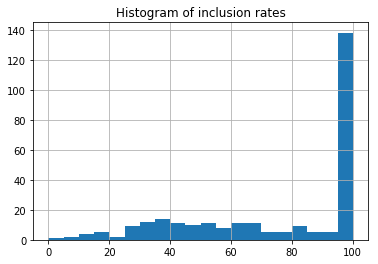

In [178]:
plt.hist(inclusion_rates, bins=20)
plt.title('Histogram of inclusion rates')
plt.grid()
plt.show()

In [179]:
# mean inclusion rate
np.mean(np.array(inclusion_rates))

# before I filtered out stop words and non-alphanumeric tokens my inclusion rate was
    # 81.56730215827338
    # this histogram had a hump at the 60% tick and almost nothing below the 40% tick

75.20111510791368

In [180]:
# median inclusion rate
np.median(np.array(inclusion_rates))

# before I filtered out stop words and non-alphanumeric tokens median was
    # 94.285

93.215

#### examine extra_bagage_rate (analagous to false positive rate)

In [187]:
print(extra_baggage_rate)
print("----------------")
print('mean bagage rate: ', np.mean(np.array(extra_baggage_rate)))
print('median bagage rate: ', np.median(np.array(extra_baggage_rate)))
print("")

[9.66, 12.06, 38.55, 2.36, 8.51, 7.75, 38.04, 23.8, 16.28, 62.86, 31.03, 8.91, 35.8, 52.85, 22.05, 33.85, 51.92, 19.23, 55.26, 4.38, 45.56, 7.95, 20.23, 0.0, 23.16, 28.68, 16.0, 3.23, 14.88, 31.49, 53.94, 25.84, 37.31, 24.88, 23.99, 11.06, 32.09, 4.17, 12.1, 3.6, 6.64, 18.9, 20.56, 6.07, 52.16, 40.69, 58.62, 45.17, 5.53, 25.91, 11.16, 37.38, 35.61, 13.43, 16.9, 8.51, 19.64, 13.58, 28.38, 29.93, 28.62, 20.85, 2.7, 37.43, 16.93, 10.22, 13.19, 34.57, 11.41, 48.71, 32.64, 23.81, 7.76, 37.15, 24.0, 27.74, 41.36, 35.45, 40.96, 40.75, 37.22, 17.77, 20.82, 7.48, 23.89, 3.37, 15.04, 29.6, 21.76, 14.14, 23.91, 45.54, 13.36, 7.65, 14.84, 40.99, 26.66, 33.78, 29.14, 35.07, 30.06, 27.67, 41.7, 24.38, 11.62, 51.8, 34.32, 16.58, 6.04, 15.57, 20.95, 36.49, 13.97, 10.17, 11.28, 9.85, 24.55, 43.99, 41.86, 8.18, 23.77, 21.18, 34.44, 28.46, 43.88, 6.33, 51.29, 15.46, 23.51, 28.32, 25.68, 29.77, 32.26, 19.62, 29.67, 16.55, 66.82, 20.71, 44.24, 45.16, 11.46, 15.94, 23.05, 25.0, 32.34, 8.33, 31.46, 20.4, 47.

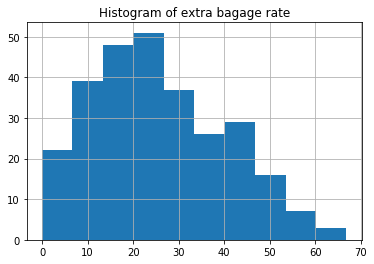

In [192]:
plt.hist(extra_baggage_rate)
plt.title('Histogram of extra bagage rate')
plt.grid()
plt.show()

This histogram shows that for the majority of my nominees, 5 - 35% of their tokens are not in the actual tokens. 
- The maximum baggage percentage looks like 65% which means about two thirds of the tokens are extra baggage not found in the actual tokens

#### compare the lengths of the actual paratokens to the nominated paratokens

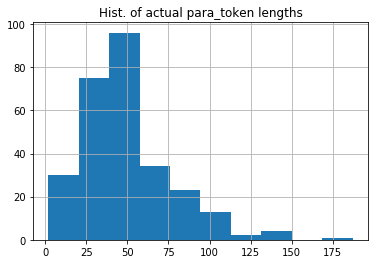

In [182]:
#plt.plot(actu)
plt.hist(actual_paratokens_lengths)
plt.title('Hist. of actual para_token lengths')
plt.grid()
plt.show()

In [196]:
print('mean ', np.mean(np.array(actual_paratokens_lengths)))
print('median', np.median(np.array(actual_paratokens_lengths)))
print('range', np.max(np.array(actual_paratokens_lengths)) - np.min(np.array(actual_paratokens_lengths)))

mean  49.514388489208635
median 45.5
range 185


**Now lets take a look at the nominated paratokens lengths**

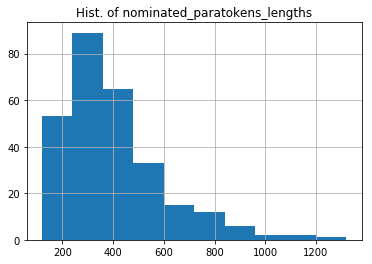

In [183]:
plt.hist(nominated_paratokens_lengths)
plt.title('Hist. of nominated_paratokens_lengths')
plt.grid()
plt.show()

In [197]:
print('mean ', np.mean(np.array(nominated_paratokens_lengths)))
print('median', np.median(np.array(nominated_paratokens_lengths)))
print('range', np.max(np.array(nominated_paratokens_lengths)) - np.min(np.array(nominated_paratokens_lengths)))


mean  400.8705035971223
median 353.0
range 1200


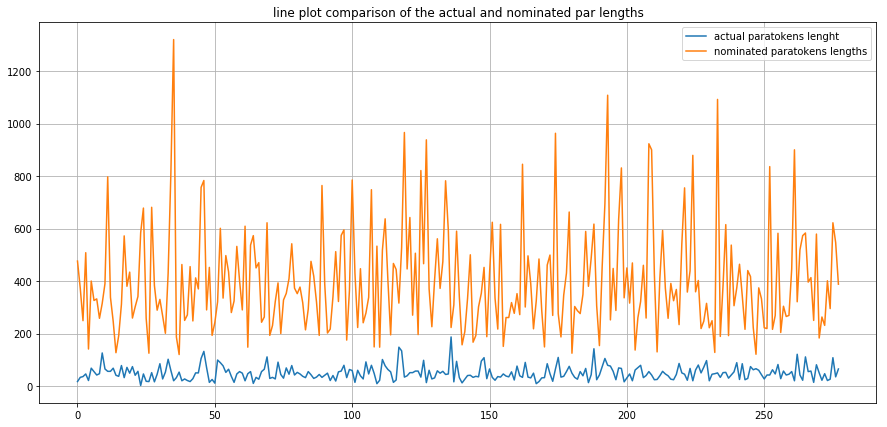

In [213]:
plt.figure(figsize = (15,7))
plt.plot(actual_paratokens_lengths)
plt.plot(nominated_paratokens_lengths)
plt.grid()
plt.title('line plot comparison of the actual and nominated par lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.show()

Hmmm.... It looks like I am definitely including more content than they are. but at least my pipeline has a regular behavior, 
- it's not like it ever includes way to much,
    - at worst it includes about 10 times too much
- and it never includes too little. 

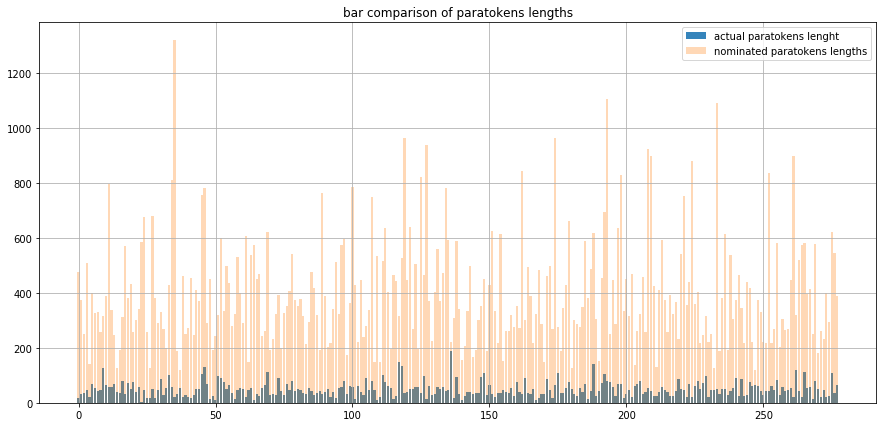

In [218]:
plt.figure(figsize = (15,7))
plt.bar(height = actual_paratokens_lengths, alpha = 0.9,
        x = range(len(actual_paratokens_lengths)))
plt.bar(height = nominated_paratokens_lengths, alpha = 0.3,
       x = range(len(nominated_paratokens_lengths)))
plt.title('bar comparison of paratokens lengths')
plt.legend(['actual paratokens lenght', 'nominated paratokens lengths'])
plt.grid()
plt.show()

### For now, ranking paragraphs by something as unrefined as brute length is working well enough
### filtering the candidate paragraphs to those containing 'repurchase' worked well too. 

## 🤔 💡 
#### can enhance by counting how many key_token hits each paragraph has
#### can enhance by assigning weighted values to certain key_tokens

# Just how *good* are my inclusion rates?
- If my nominated paragraphs are excessively long, then they are likely to have high inclusion (both total and partial) merely because they include too much. 
    - if my nominated paragraph was the entire HTML then i would have 100% inclusion

##  Verification Metrics
1. ✅ Inspect the length of my nominated paragraphs. 
    - compare them to the length of the actual paragraphs
        - *Although, don't weight the actual paragraphs too heavily, my confidence in the original csv they gave us has diminished*
            - there is a 25 - 50 % rate of noncorrespondance between a rows text and it's paragraph
            
2. ✅ Improve the inclusion rates by filtering out the stop words before calculating them. (filter out punctuation as well?)
    - If an actual paragraph is 90% stop words then i'm likely to include 90% of it in any sufficiently long arbitrary english language paragraph. 🤦‍♂️ 
    - Also, calculate what % of my nominee paragraphs corresopnd to the overlap with the actual paragraphs (the "center" of the Venn Diagram)
        - and, calculate what percentage corresponds to the content that does not overlap with the actual paragraphs (the nominee's side of the Venn Diagram)

3. ✅ Improve my calculation of total inclusion by ensuring the actual paragraphs don't have too many new line characters.

# Can disregard the code below, it's just me working through the verification improvements

### 2. Improve the inclusion rates by filtering out the stop words before calculating them

In [158]:
actual_paragraph = vert_training_subset_df.head(1).paragraph_text
    # extract the string from the resulting pandas series
actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
actual_paragraph

'on may 28, 2015 we announced that our board of directors had approved a new share repurchase program (the "2015 repurchase program"). the 2015 share repurchase program authorizes the purchase of up to $1.14 billion of our common stock at the company\'s discretion through and including november 1, 2018. the 2015 repurchase program does not require the company to acquire a specific number of shares and may be suspended or discontinued at any time. during the year ended october 31, 95'

In [166]:
# ok, the word_tokenized version includes punctuation and dollar signs
print(word_tokenize(actual_paragraph))
print("")
print(len(word_tokenize(actual_paragraph)))

['on', 'may', '28', ',', '2015', 'we', 'announced', 'that', 'our', 'board', 'of', 'directors', 'had', 'approved', 'a', 'new', 'share', 'repurchase', 'program', '(', 'the', '``', '2015', 'repurchase', 'program', "''", ')', '.', 'the', '2015', 'share', 'repurchase', 'program', 'authorizes', 'the', 'purchase', 'of', 'up', 'to', '$', '1.14', 'billion', 'of', 'our', 'common', 'stock', 'at', 'the', 'company', "'s", 'discretion', 'through', 'and', 'including', 'november', '1', ',', '2018.', 'the', '2015', 'repurchase', 'program', 'does', 'not', 'require', 'the', 'company', 'to', 'acquire', 'a', 'specific', 'number', 'of', 'shares', 'and', 'may', 'be', 'suspended', 'or', 'discontinued', 'at', 'any', 'time', '.', 'during', 'the', 'year', 'ended', 'october', '31', ',', '95']

92


In [167]:
# this filter will eliminate dollar signs and punctuation
print([wt for wt in word_tokenize(actual_paragraph) if wt.isalnum()])
print("")
print(len([wt for wt in word_tokenize(actual_paragraph) if wt.isalnum()]))

['on', 'may', '28', '2015', 'we', 'announced', 'that', 'our', 'board', 'of', 'directors', 'had', 'approved', 'a', 'new', 'share', 'repurchase', 'program', 'the', '2015', 'repurchase', 'program', 'the', '2015', 'share', 'repurchase', 'program', 'authorizes', 'the', 'purchase', 'of', 'up', 'to', 'billion', 'of', 'our', 'common', 'stock', 'at', 'the', 'company', 'discretion', 'through', 'and', 'including', 'november', '1', 'the', '2015', 'repurchase', 'program', 'does', 'not', 'require', 'the', 'company', 'to', 'acquire', 'a', 'specific', 'number', 'of', 'shares', 'and', 'may', 'be', 'suspended', 'or', 'discontinued', 'at', 'any', 'time', 'during', 'the', 'year', 'ended', 'october', '31', '95']

79


In [168]:
# this filter will eliminate dollar signs and punctuation
# does it also eliminate stop words?
print([wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))])
print("")
print(len([wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))]))

['may', '28', '2015', 'announced', 'board', 'directors', 'approved', 'new', 'share', 'repurchase', 'program', '2015', 'repurchase', 'program', '2015', 'share', 'repurchase', 'program', 'authorizes', 'purchase', 'billion', 'common', 'stock', 'company', 'discretion', 'including', 'november', '1', '2015', 'repurchase', 'program', 'require', 'company', 'acquire', 'specific', 'number', 'shares', 'may', 'suspended', 'discontinued', 'time', 'year', 'ended', 'october', '31', '95']

46


Well damn! 50% of my content was either punctuation, stopwords, or non-alphanumeric.
- that could really throw off my inclusion rate calculations

In [170]:
actual_paragraph = vert_training_subset_df.head(1).paragraph_text
    # extract the string from the resulting pandas series
actual_paragraph = actual_paragraph.values[0]
    # cast the string to lower case
actual_paragraph = actual_paragraph.lower()
    # eliminate excess spaces
actual_paragraph = re.sub(r'\s+', ' ', actual_paragraph)
actual_tokens = [wt for wt in word_tokenize(actual_paragraph) if (wt.isalnum() and wt not in stopwords.words('english'))]
print(actual_tokens)


['may', '28', '2015', 'announced', 'board', 'directors', 'approved', 'new', 'share', 'repurchase', 'program', '2015', 'repurchase', 'program', '2015', 'share', 'repurchase', 'program', 'authorizes', 'purchase', 'billion', 'common', 'stock', 'company', 'discretion', 'including', 'november', '1', '2015', 'repurchase', 'program', 'require', 'company', 'acquire', 'specific', 'number', 'shares', 'may', 'suspended', 'discontinued', 'time', 'year', 'ended', 'october', '31', '95']


In [ ]:
# apply the same filtering process to nom_validatable
nominated_tokens = [wt for wt in word_tokenize(nom_validatable) if (wt.isalnum() and wt not in stopwords.words('english'))]


In [ ]:
counter = 0
for wt in actual_tokens:
    if wt in nominated_tokens:
        counter += 1
    #print('word tokens actual_paragraph also in word_tokenise(nom_validatable)')
    #print('---------- counter = ', counter)
x = round(100*counter/len(actual_tokens),2)

### 3. Check if the actual paragraphs have exces new line characthers that might be throwing off the total inclusion measurement

In [147]:
# 3. Check if the actual paragraphs have exces new line characthers that might be throwing off the total inclusion measurement
['\n' in 'This is a test string with a line break in it.\nAnd then another sentence.']

[True]

In [150]:
np.array(['\n' in par for par in vert_training_subset_df.paragraph_text]).sum()

0

✅ Ok, Looks like there are no new line characters in the actual paragraphs

In [155]:
# check to see if there are double spaces in there.
np.array(['  ' in par for par in vert_training_subset_df.paragraph_text]).sum()

411

✅ There are multiple double spaces in the paragraphs but those have already been handled by the above "pipeline"
- there are other characters in thee like '^, /, (, ),' but I don't feel like regexing those out manually, the rate of overlap should be captured by improvement 2. above.

In [156]:
for par in vert_training_subset_df.paragraph_text:
    print(par)
    print('-----------------')

On May 28, 2015 we  announced that our board  of directors had approved a  new share repurchase program  (the   "2015 repurchase program"). The 2015 share repurchase program authorizes the purchase of up to $1.14  billion   of our common stock at the company's discretion  through and including November 1, 2018. The 2015  repurchase   program does  not require  the company  to  acquire a  specific number  of  shares and  may be  suspended  or   discontinued at any time. During the year ended October 31,                                                        95
-----------------
Table of Contents   2016, upon the completion of our previous repurchase program, we repurchased approximately 8.3 million shares   for $336  million  under  this  authorization.  During  the  year  ended  October  31,  2017  we  repurchased   approximately 4.1 million shares for $194  million under this authorization. As  of October 31, 2017, we  had   remaining authorization to repurchase up to $610 million of 